In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Try increasing the chunk size
data = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding = "latin-1", engine="c", nrows=100000)

# Or, ignore malformed lines

data.columns = ["label", "time", "date", "query", "username", "text"]

In [3]:
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
data.tail()

,label,time,date,query,username,text
42367,0,1676064993,Fri May 01 21:00:32 PDT 2009,NO_QUERY,lovehaightpeace,I wish Eric Draven was real.
42368,0,1676065032,Fri May 01 21:00:32 PDT 2009,NO_QUERY,bhillss,exam time
42369,0,1676065247,Fri May 01 21:00:34 PDT 2009,NO_QUERY,OxCheliJoxO,is gettin sick! Damn! Go figure I have big wee...
42370,0,1676065305,Fri May 01 21:00:35 PDT 2009,NO_QUERY,exeromai,Had to leave after shooting 1st 3 songs of Dea...
42371,0,1676065473,Fri May 01 21:00:36 PDT 2009,NO_QUERY,trslove,NaN


In [5]:
data.columns


Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [6]:
data.shape

(42372, 6)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     42372 non-null  int64 
 1   time      42372 non-null  int64 
 2   date      42372 non-null  object
 3   query     42372 non-null  object
 4   username  42372 non-null  object
 5   text      42371 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [8]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

In [9]:
np.sum(data.isnull().any(axis=1))

1

In [10]:
print('Count of columns in the data is:  ', len(data.columns))

Count of columns in the data is:   6


In [11]:
print('Count of rows in the data is:  ', len(data))

Count of rows in the data is:   42372


In [12]:
data=data[['text','label']]

In [13]:
data['label'][data['label']==4]=1

In [14]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [15]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [16]:
data = pd.concat([data_pos, data_neg])

In [17]:
data['text']=data['text'].str.lower()

In [18]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [19]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

19995                            one more day of holidays 
19996    feeling so down right now  i hate you damn hum...
19997    geezi hv to read the whole book of personality...
19998    i threw my sign at donnie and he bent over to ...
19999    heather2711 good thing i didnt find any then  ...
Name: text, dtype: object

In [20]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [21]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

19995                            one more day of holidays 
19996    feling so down right now i hate you damn humprey 
19997    gezi hv to read the whole bok of personality t...
19998    i threw my sign at donie and he bent over to g...
19999    heather271 god thing i didnt find any then non...
Name: text, dtype: object

In [22]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [23]:
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

19995                            one more day of holidays 
19996    feling so down right now i hate you damn humprey 
19997    gezi hv to read the whole bok of personality t...
19998    i threw my sign at donie and he bent over to g...
19999    heather271 god thing i didnt find any then non...
Name: text, dtype: object

In [24]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [25]:
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

19995                            one more day of holidays 
19996    feling so down right now i hate you damn humprey 
19997    gezi hv to read the whole bok of personality t...
19998    i threw my sign at donie and he bent over to g...
19999    heather271 god thing i didnt find any then non...
Name: text, dtype: object

In [26]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [27]:
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

19995                            one more day of holidays 
19996    feling so down right now i hate you damn humprey 
19997    gezi hv to read the whole bok of personality t...
19998    i threw my sign at donie and he bent over to g...
19999    heather god thing i didnt find any then none o...
Name: text, dtype: object

In [28]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

In [29]:
data['text'].head()

0    [is, upset, that, he, cant, update, his, faceb...
1    [kenichan, i, dived, many, times, for, the, ba...
2    [my, whole, body, fels, itchy, and, like, its,...
3    [nationwideclas, no, its, not, behaving, at, a...
4                    [kwesidei, not, the, whole, crew]
Name: text, dtype: object

In [30]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [31]:
data['text'].head()

0    [is, upset, that, he, cant, update, his, faceb...
1    [kenichan, i, dived, many, times, for, the, ba...
2    [my, whole, body, fels, itchy, and, like, its,...
3    [nationwideclas, no, its, not, behaving, at, a...
4                    [kwesidei, not, the, whole, crew]
Name: text, dtype: object

In [32]:
X=data.text
y=data.label

In [33]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [34]:
sequences_matrix.shape

(20000, 500)

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [36]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call itdef tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

In [37]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [45]:
history=model.fit(X_train,Y_train,batch_size=50,epochs=2, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/2
252/252 [==============================] - 97s 383ms/step - loss: 2.8029e-06 - accuracy: 1.0000 - val_loss: 5.4622e-07 - val_accuracy: 1.0000
Epoch 2/2
252/252 [==============================] - 94s 374ms/step - loss: 2.1725e-06 - accuracy: 1.0000 - val_loss: 4.2112e-07 - val_accuracy: 1.0000
Training finished !!


In [47]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

188/188 [==============================] - 16s 82ms/step - loss: 4.2098e-07 - accuracy: 1.0000


In [40]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 1.00


In [41]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)

188/188 [==============================] - 25s 132ms/step




confusion matrix


[[6000]]




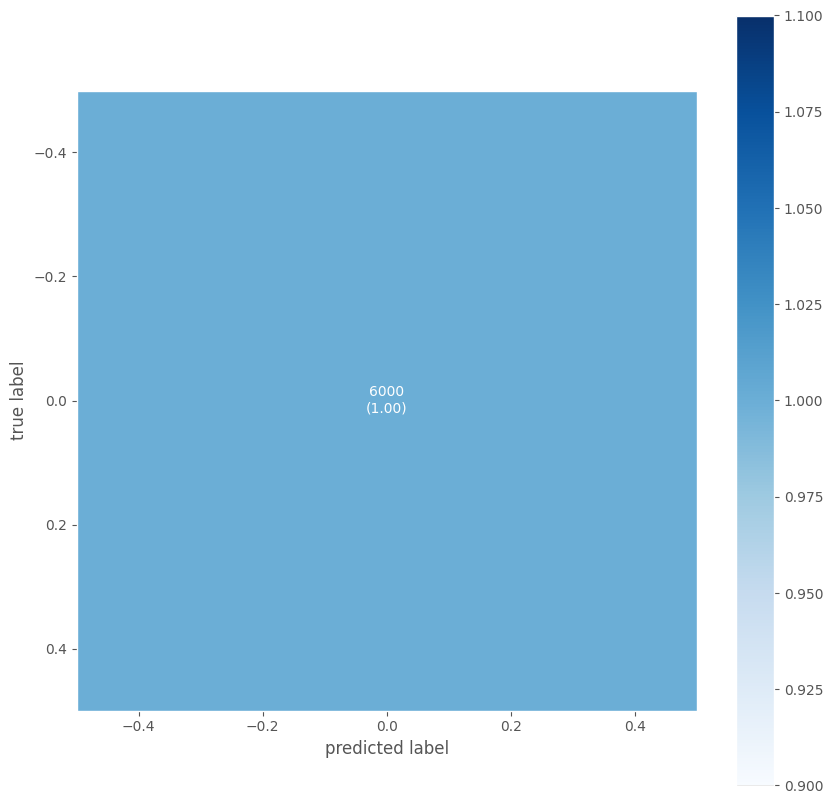

In [46]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

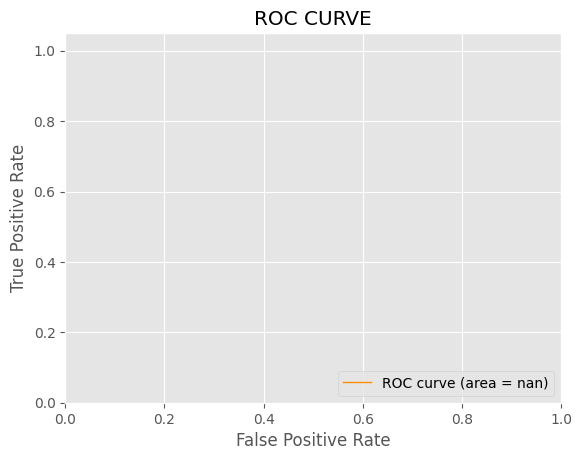

In [44]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()